# AVI-DYS Time Series Classification (Five Classes)

## Import Libraries

In [1]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import itertools
from sklearn.model_selection import StratifiedKFold
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [2]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

save_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Analyses\\Cross-Validation"

# Functions

In [3]:
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=5)

    # Print the folds
    for i, (train_index, test_index) in enumerate(k_fold.split(data_x, data_y)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        classifier = hc2.fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [4]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    accuracy = round(accuracy_score(actual_target, predicted_target) * 100, ndigits=2)
    plt.annotate(f'Accuracy = {accuracy}%',xy = (0.0, -.25),
           xycoords='axes fraction',
           ha='left',
           va="center",
           fontsize='medium',
           family='serif',
           wrap=True)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [5]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title=f'{Measure} without normalization')
    
    # Save the confusion matrix
    png = str(os.path.join(save_path,f"confusion-matrix-{Measure}.png"))
    svg = str(os.path.join(save_path,f"confusion-matrix-{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title=f'{Measure} (Normalized)')
    png = str(os.path.join(save_path,f"normalized-confusion-matrix-{Measure}.png"))
    svg = str(os.path.join(save_path,f"normalized-confusion-matrix-{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')
    plt.show()

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [6]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [7]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]


## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [8]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [9]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [10]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

#### Predict the Dystonia Duration Scores

In [11]:
class_names = ['DIS-0','DIS-1','DIS-2','DIS-3','DIS-4']

In [12]:
# Create the classifier
hc2 =HIVECOTEV2(
    stc_params=None,
    drcif_params=None,
    arsenal_params=None,
    tde_params=None,
    time_limit_in_minutes=2,
    save_component_probas=False,
    verbose=0,
    #n_jobs=-1,
    random_state=42,
)

c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0:
  Train: index=[ 3  4  5  6  7 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 63 64 65]
  Test:  index=[ 0  1  2  8  9 10 11 12 13 14 15 16 35 62]
Fold 1:
  Train: index=[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 3  4 17 18 19 20 21 22 23 24 25 46 47]
Fold 2:
  Train: index=[ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 5  6 26 27 28 29 30 31 32 33 34 44 52]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 44 46 47 49 50 51 52 53 54 55 56 57 59
 60 61 62 63 65]
  Test:  index=[ 7 36 37 38 39 40 41 42 43 45 48 58 64]
Fold 4:
  Train: index=[ 0  1  2

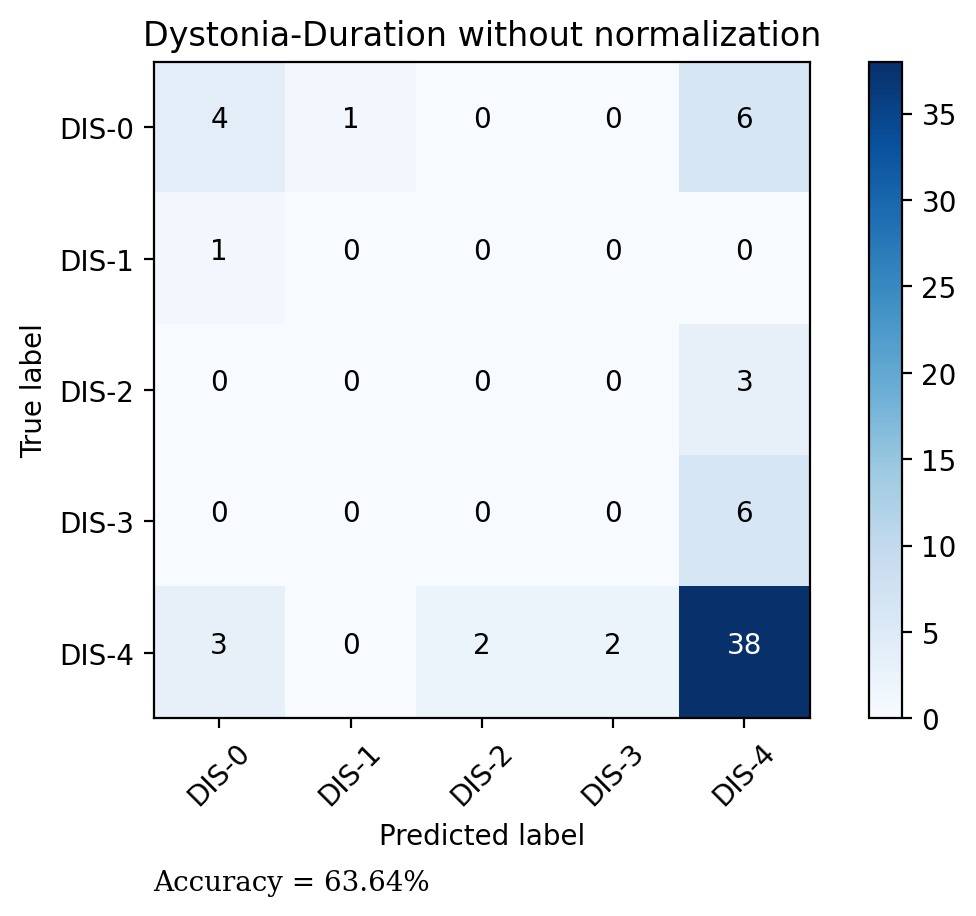

Normalized confusion matrix


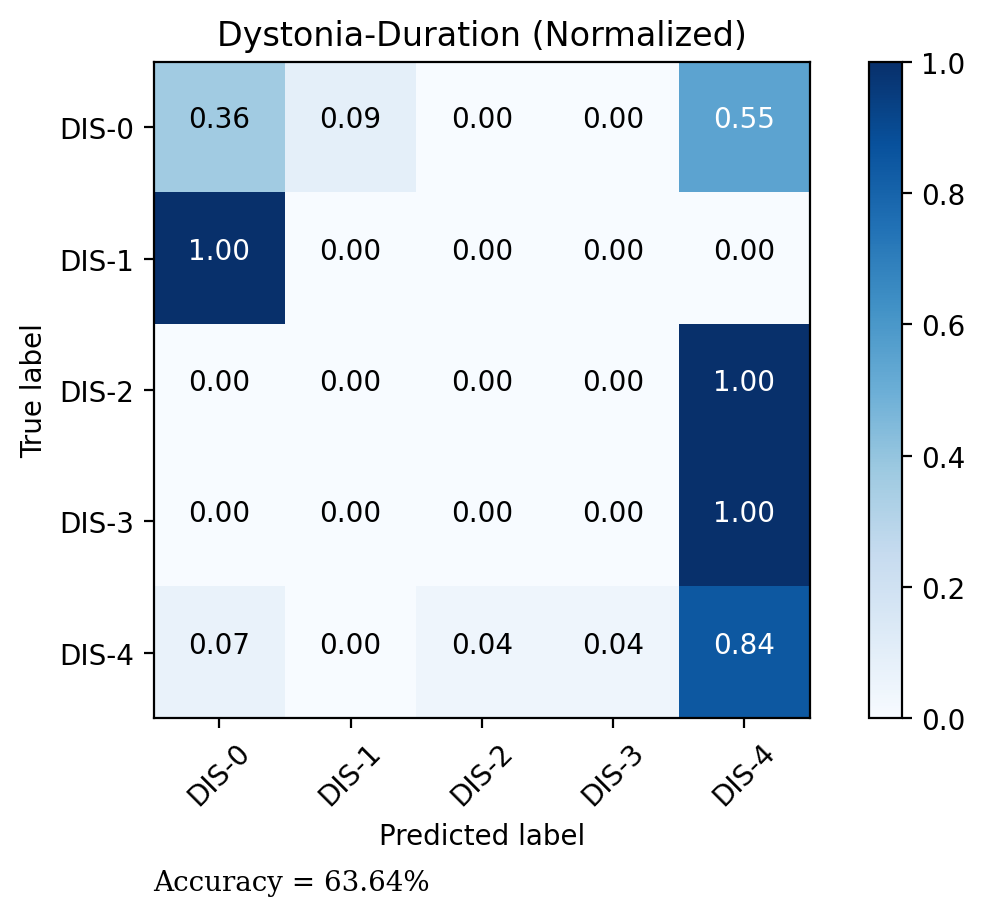

              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           4       0.72      0.84      0.78        45

    accuracy                           0.64        66
   macro avg       0.24      0.24      0.24        66
weighted avg       0.57      0.64      0.60        66



In [13]:
Measure = 'Dystonia-Duration'

# Get the relevant column from the outcome measures
y = Y[Measure].astype(str).to_numpy()

# Fit the classifier on all folds
predicted_target, actual_target = evaluate_model(X, y)

# Save the y train-test split and predictions
df_y_train = pd.DataFrame({'DIS-Score': y, 'split': 'y_train'})
df_y_pred = pd.DataFrame({'DIS-Score': predicted_target, 'split': 'y_pred'})
df = pd.concat([df_y_train, df_y_pred], ignore_index=True)
df.to_csv(os.path.join(save_path,f'y-{Measure}.csv'))

# Plot thte confusion matrices
plot_confusion_matrix(predicted_target, actual_target)

# Print the classification report
print(classification_report(actual_target, predicted_target))

#### Predict the Dystonia Amplitude Scores

Fold 0:
  Train: index=[ 3  4  5  6  7 17 18 19 20 21 22 23 24 25 26 27 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 63 64 65]
  Test:  index=[ 0  1  2  8  9 10 11 12 13 14 15 16 28 62]
Fold 1:
  Train: index=[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 24 25 26 28 30 31 32 33 34
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 3  4 17 18 19 20 21 22 23 27 29 35 36]
Fold 2:
  Train: index=[ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 27 28
 29 35 36 37 38 39 40 41 42 43 45 46 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 5  6 24 25 26 30 31 32 33 34 44 47 48]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 44 45 46 47 48 51 52 53 55 56 57 59
 61 62 63 64 65]
  Test:  index=[ 7 37 38 39 40 41 42 43 49 50 54 58 60]
Fold 4:
  Train: index=[ 0  1  2

c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Confusion matrix, without normalization


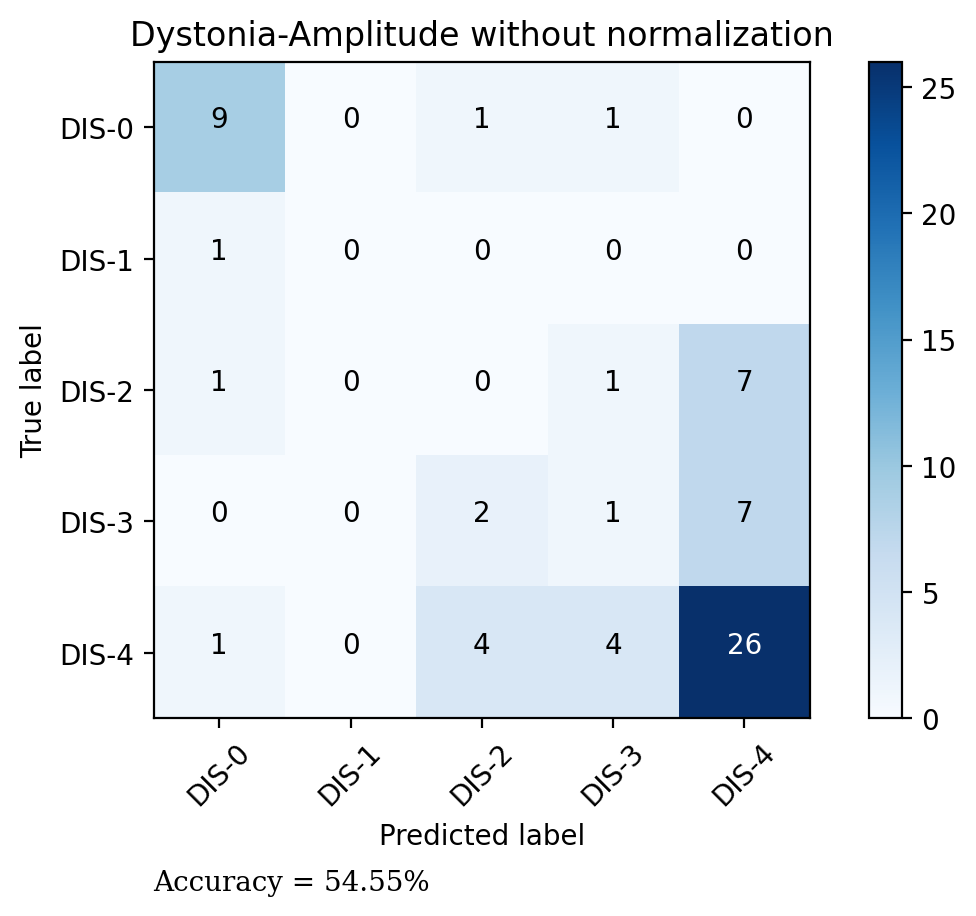

Normalized confusion matrix


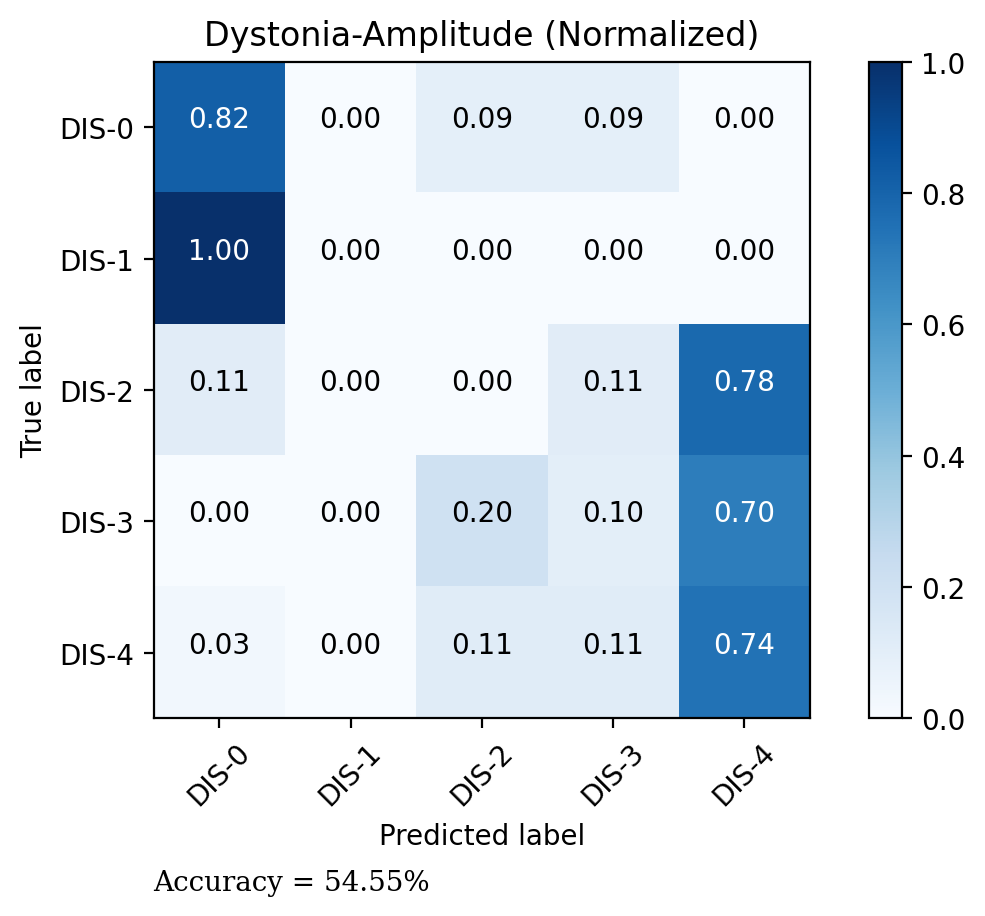

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         9
           3       0.14      0.10      0.12        10
           4       0.65      0.74      0.69        35

    accuracy                           0.55        66
   macro avg       0.31      0.33      0.32        66
weighted avg       0.49      0.55      0.52        66



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
Measure = 'Dystonia-Amplitude'

# Get the relevant column from the outcome measures
y = Y[Measure].astype(str).to_numpy()

# Fit the classifier on all folds
predicted_target, actual_target = evaluate_model(X, y)

# Save the y train-test split and predictions
df_y_train = pd.DataFrame({'DIS-Score': y, 'split': 'y_train'})
df_y_pred = pd.DataFrame({'DIS-Score': predicted_target, 'split': 'y_pred'})
df = pd.concat([df_y_train, df_y_pred], ignore_index=True)
df.to_csv(os.path.join(save_path,f'y-{Measure}.csv'))

# Plot thte confusion matrices
plot_confusion_matrix(predicted_target, actual_target)

# Print the classification report
print(classification_report(actual_target, predicted_target))

#### Predict the Choreoathetosis Duration Scores

Fold 0:
  Train: index=[ 4  5  6  7 11 15 18 20 21 22 23 24 25 26 27 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65]
  Test:  index=[ 0  1  2  3  8  9 10 12 13 14 16 17 19 28]
Fold 1:
  Train: index=[ 0  1  2  3  8  9 10 12 13 14 16 17 19 20 21 22 23 25 26 27 28 30 34 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 4  5  6  7 11 15 18 24 29 31 32 33 35]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 24 25 28
 29 30 31 32 33 34 35 38 44 45 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[20 21 22 26 27 36 37 39 40 41 42 43 46]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 26 27 28 29 31 32 33 35 36 37 39 40 41 42 43 45 46 48 49 55 56 57 58 59
 60 61 63 64 65]
  Test:  index=[23 25 30 34 38 44 47 50 51 52 53 54 62]
Fold 4:
  Train: index=[ 0  1  2

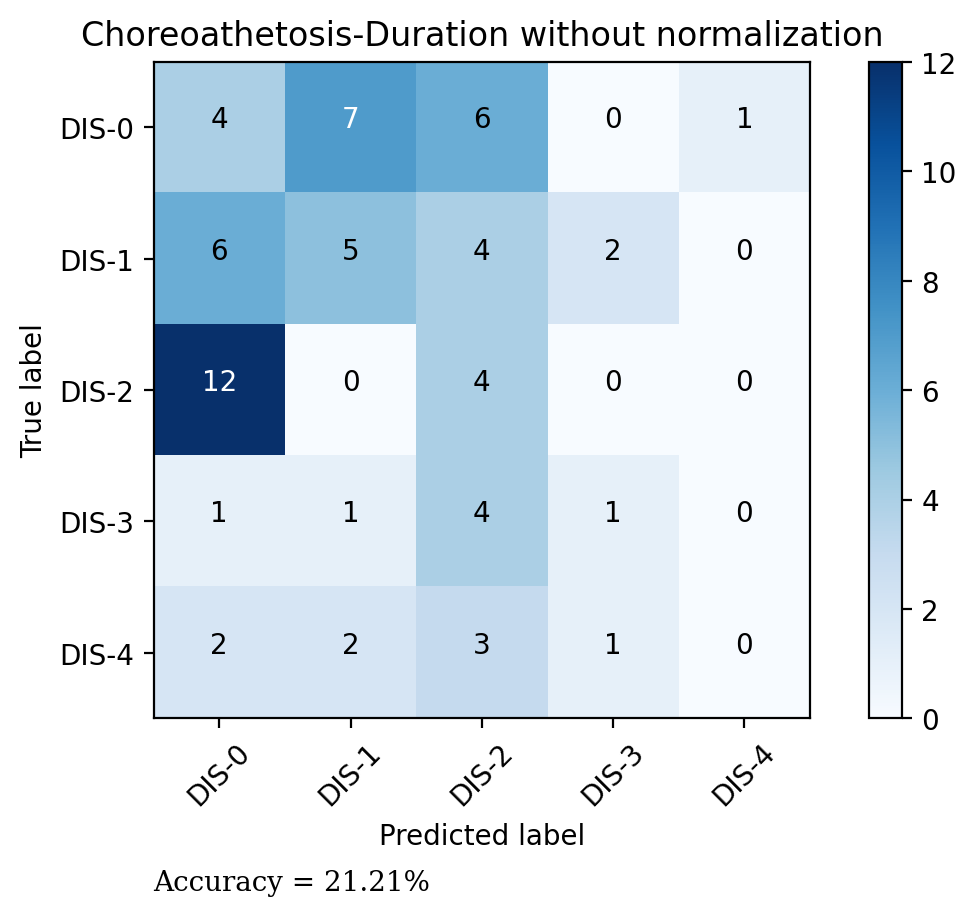

Normalized confusion matrix


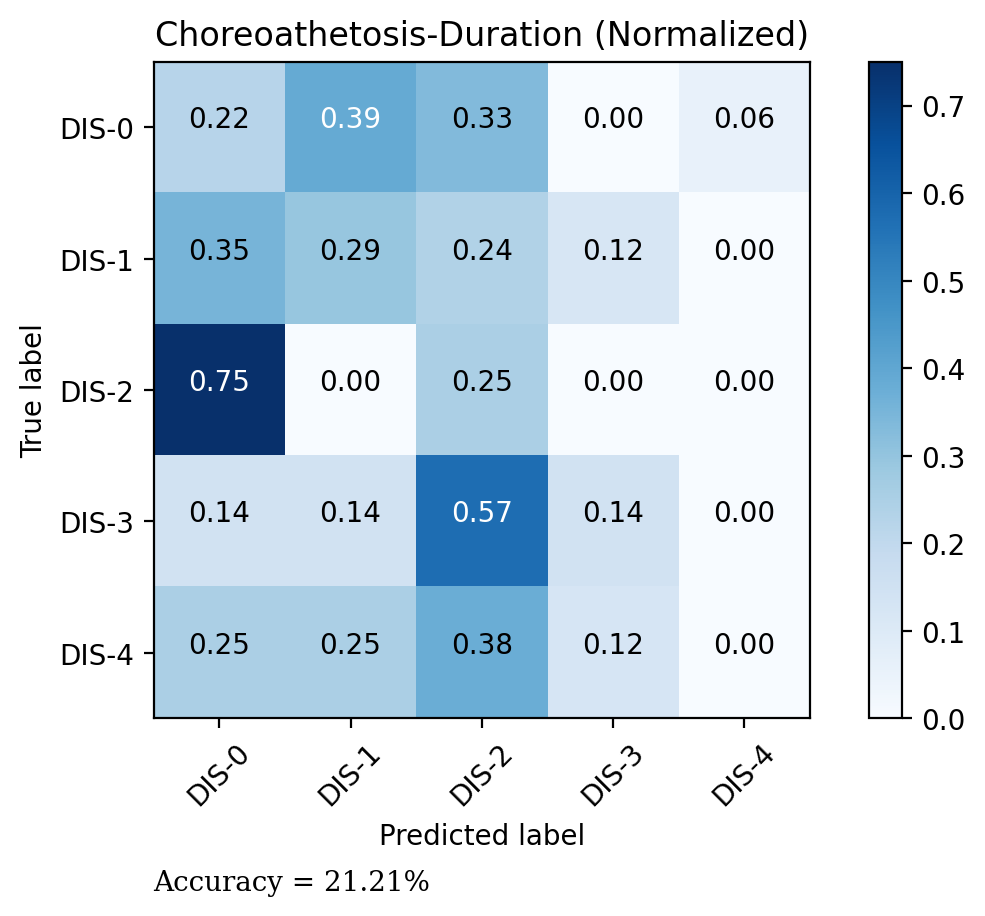

              precision    recall  f1-score   support

           0       0.16      0.22      0.19        18
           1       0.33      0.29      0.31        17
           2       0.19      0.25      0.22        16
           3       0.25      0.14      0.18         7
           4       0.00      0.00      0.00         8

    accuracy                           0.21        66
   macro avg       0.19      0.18      0.18        66
weighted avg       0.20      0.21      0.20        66



In [15]:
Measure = 'Choreoathetosis-Duration'

# Get the relevant column from the outcome measures
y = Y[Measure].astype(str).to_numpy()

# Fit the classifier on all folds
predicted_target, actual_target = evaluate_model(X, y)

# Save the y train-test split and predictions
df_y_train = pd.DataFrame({'DIS-Score': y, 'split': 'y_train'})
df_y_pred = pd.DataFrame({'DIS-Score': predicted_target, 'split': 'y_pred'})
df = pd.concat([df_y_train, df_y_pred], ignore_index=True)
df.to_csv(os.path.join(save_path,f'y-{Measure}.csv'))

# Plot thte confusion matrices
plot_confusion_matrix(predicted_target, actual_target)

# Print the classification report
print(classification_report(actual_target, predicted_target))

#### Predict the Choreoathetosis Amplitude Scores

c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 0:
  Train: index=[ 4  5  6  7 15 16 18 20 21 22 23 24 25 26 27 28 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65]
  Test:  index=[ 0  1  2  3  8  9 10 11 12 13 14 17 19 29]
Fold 1:
  Train: index=[ 0  1  2  3  8  9 10 11 12 13 14 17 19 20 21 23 24 26 27 28 29 30 34 35
 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[ 4  5  6  7 15 16 18 22 25 31 32 33 37]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 25 28 29
 30 31 32 33 34 37 38 41 42 45 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65]
  Test:  index=[20 21 23 24 26 27 35 36 39 40 43 44 46]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 31 32 33 35 36 37 39 40 41 42 43 44 45 46 54 56 57 58 59
 60 61 63 64 65]
  Test:  index=[28 30 34 38 47 48 49 50 51 52 53 55 62]
Fold 4:
  Train: index=[ 0  1  2

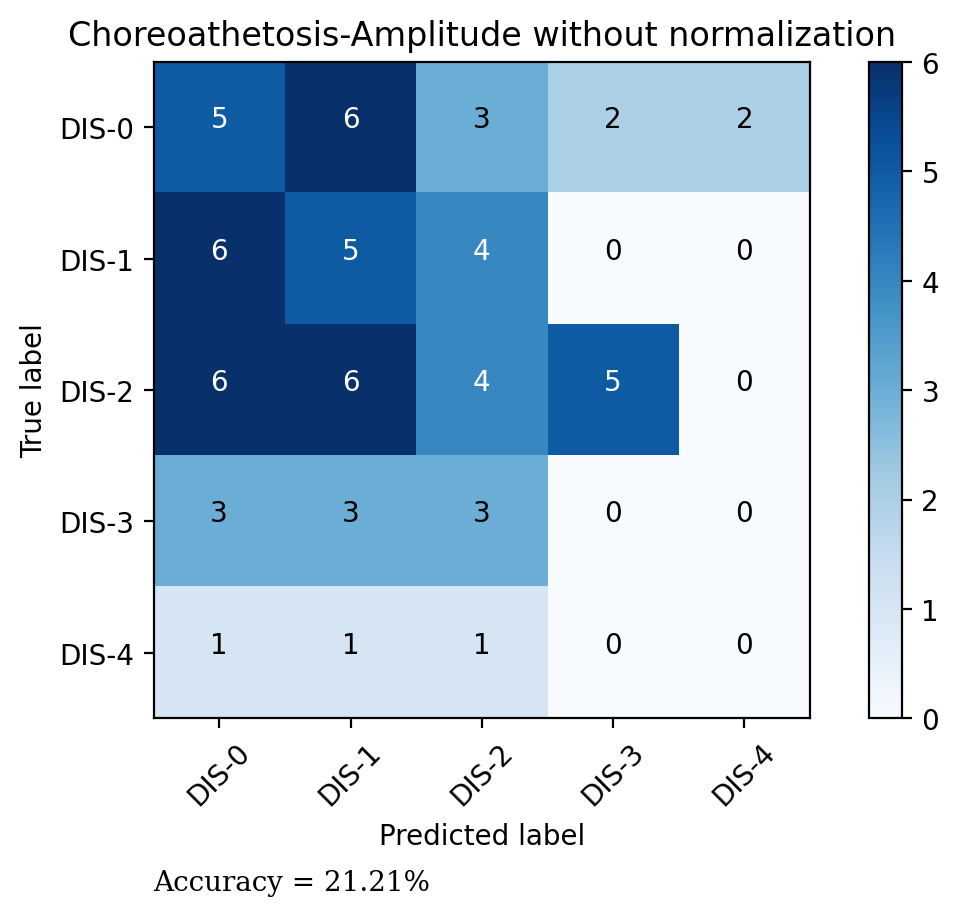

Normalized confusion matrix


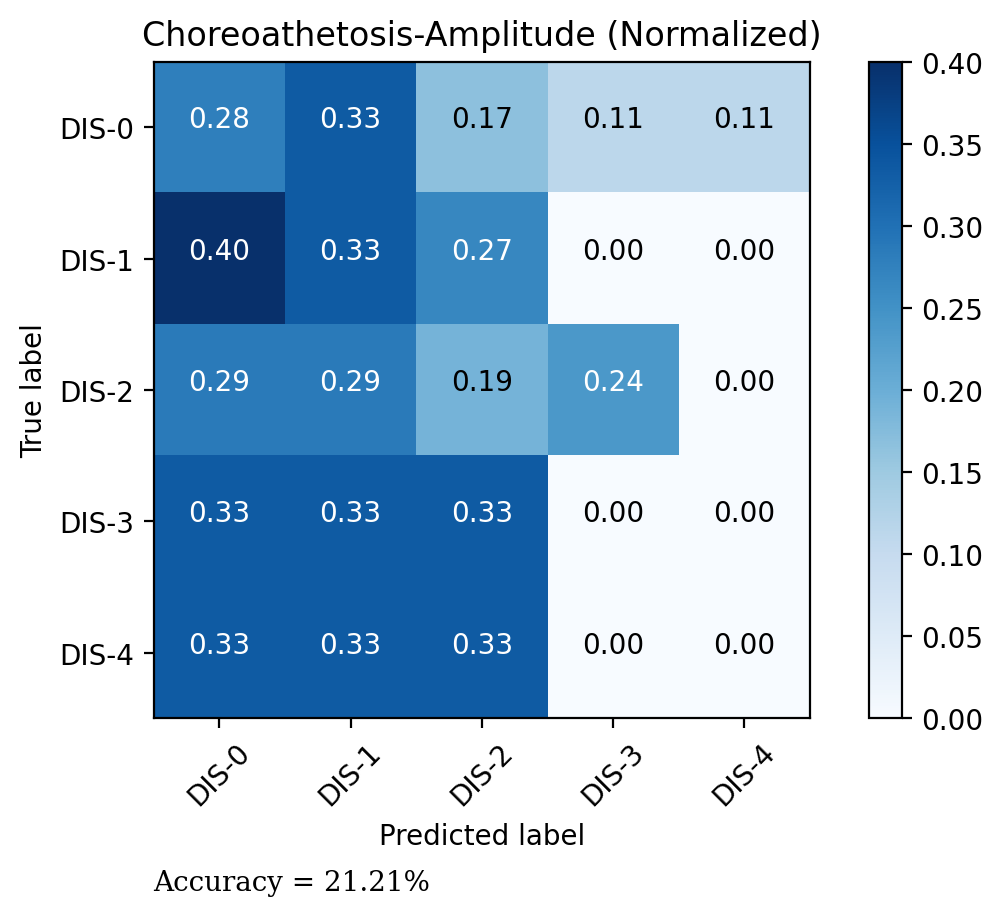

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        18
           1       0.24      0.33      0.28        15
           2       0.27      0.19      0.22        21
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3

    accuracy                           0.21        66
   macro avg       0.15      0.16      0.15        66
weighted avg       0.20      0.21      0.20        66



In [16]:
Measure = 'Choreoathetosis-Amplitude'

# Get the relevant column from the outcome measures
y = Y[Measure].astype(str).to_numpy()

# Fit the classifier on all folds
predicted_target, actual_target = evaluate_model(X, y)

# Save the y train-test split and predictions
df_y_train = pd.DataFrame({'DIS-Score': y, 'split': 'y_train'})
df_y_pred = pd.DataFrame({'DIS-Score': predicted_target, 'split': 'y_pred'})
df = pd.concat([df_y_train, df_y_pred], ignore_index=True)
df.to_csv(os.path.join(save_path,f'y-{Measure}.csv'))

# Plot thte confusion matrices
plot_confusion_matrix(predicted_target, actual_target)

# Print the classification report
print(classification_report(actual_target, predicted_target))